# Fake News detection with tensorflow and nltk using LSTMs

## Import required packages

In [26]:
# Import all necessary libraries for preprocessing and model building
import re
from typing import Iterable

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             recall_score, roc_curve)
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

plt.style.use("ggplot")

## Download dataset from kaggle

In [ ]:
# Install kaggle library
!pip install -q kaggle

In [ ]:
# Import kaggle API token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jakubgrzywaczewski","key":"02affd25222c7add1574dcd931b8b90c"}'}

In [ ]:
# Activate kaggle token
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset as zip
!kaggle datasets download mohammadaflahkhan/fake-news-dataset-combined-different-sources

 90% 72.0M/80.3M [00:01<00:00, 50.9MB/s]
100% 80.3M/80.3M [00:01<00:00, 44.8MB/s]


In [ ]:
!mkdir data
!unzip fake-news-dataset-combined-different-sources.zip -d data
!mv ./data/PreProcessedData.csv ./data/RawKaggleData.csv

Archive:  fake-news-dataset-combined-different-sources.zip
  inflating: data/PreProcessedData.csv  


## Data - first look

In [ ]:
# Load dataset
df = pd.read_csv("./data/RawKaggleData.csv")

In [ ]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'Ground Label'], dtype='object')

In [ ]:
len(df)

69045

In [ ]:
df.head()

,Unnamed: 0,title,text,Ground Label
0,0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


## Data split for model training / work validation

In [ ]:
df_train, df_validation = train_test_split(df, test_size=0.30, random_state=33)

In [ ]:
df_train.to_csv("fakenews-data-train.csv")
df_validation.to_csv("fakenews-data-validation.csv")

In [ ]:
!sha256sum ./fakenews-data-train.csv
!sha256sum ./fakenews-data-validation.csv

e32c170a929b4b49bf2c113032d011ee1c6a477a8d221994fbf2e7489eb74436  ./fakenews-data-train.csv
7b3ddf8388182b88ae9bab095b1c1ab762c85a3ff10b0720a2a64a5bebe46524  ./fakenews-data-validation.csv


### SHA256SUM hash
e32c170a929b4b49bf2c113032d011ee1c6a477a8d221994fbf2e7489eb74436  ./fakenews-data-train.csv
7b3ddf8388182b88ae9bab095b1c1ab762c85a3ff10b0720a2a64a5bebe46524  ./fakenews-data-validation.csv

## Download sample from GitHub

Samples:
  - Train: https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/fakenews-data-train.zip
  - Test: https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/fakenews-data-validation.zip

We as the training team will use the training sample. And leave the test sample untouched.

In [ ]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/fakenews-data-train.zip && unzip -d data fakenews-data-train.zip

--2023-03-22 21:19:28--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/fakenews-data-train.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZetrextJG/MLProject1_FakeNewsDetection/main/fakenews-data-train.zip [following]
--2023-03-22 21:19:29--  https://raw.githubusercontent.com/ZetrextJG/MLProject1_FakeNewsDetection/main/fakenews-data-train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58482753 (56M) [application/zip]
Saving to: ‘fakenews-data-train.zip’

fakenews-data-train 100%[===================>]  55.77M  --.-KB/s    in 0.1s    

2023-03-22 21:19:32 (450 MB

### Chech downloaded file using sha256sum hash

In [ ]:
!sha256sum ./data/fakenews-data-train.csv

e32c170a929b4b49bf2c113032d011ee1c6a477a8d221994fbf2e7489eb74436  ./data/fakenews-data-train.csv


## Data preprocessing

In [ ]:
# Load our data sample
df = pd.read_csv("data/fakenews-data-train.csv")

In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'title', 'text', 'Ground Label'], dtype='object')

In [ ]:
len(df)

48331

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48331 entries, 0 to 48330
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  48331 non-null  int64 
 1   Unnamed: 0    48331 non-null  int64 
 2   title         47844 non-null  object
 3   text          48282 non-null  object
 4   Ground Label  48331 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


In [ ]:
# Remove Unnamed columns as they are a residue from previous indicies
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert title, text, Ground Label columns to type of string
df = df.astype({
    "title": "string",
    "text": "string",
    "Ground Label": "string"
})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48331 entries, 0 to 48330
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         47844 non-null  string
 1   text          48282 non-null  string
 2   Ground Label  48331 non-null  string
dtypes: string(3)
memory usage: 1.1 MB


In [ ]:
df.isna().sum()

title           487
text             49
Ground Label      0
dtype: int64

In [ ]:
df[df["title"].isna() & df["text"].isna()]

,title,text,Ground Label


Sources include at least one column from "title" and "text"

In [ ]:
no_text = df[df["text"].isna()]
no_text.head()

,title,text,Ground Label
1320,Gorafi Magazine : Entretien exclusif avec Bara...,<NA>,fake
3613,“Notre batal a coulé” par l’homme qui fait des...,<NA>,fake
4709,Elections US : les premières estimations donne...,<NA>,fake
7982,Why Federalization In Syria And The Creation O...,<NA>,fake
8760,Ravens @ Raiders - Thursday,<NA>,fake


In [ ]:
no_text["Ground Label"].describe()

count       49
unique       2
top       fake
freq        48
Name: Ground Label, dtype: object

In [ ]:
df["Ground Label"].describe()

count     48331
unique        2
top        fake
freq      29507
Name: Ground Label, dtype: object

Sources with no text are not a representative of the whole sample. Therefore we will remove them from our dataframe

In [ ]:
df = df.drop(no_text.index)

In [ ]:
df["title"].describe()

count                                                 47795
unique                                                41953
top       Factbox: Trump fills top jobs for his administ...
freq                                                     13
Name: title, dtype: object

In [ ]:
df["text"].describe()

count     48282
unique    42291
top            
freq        524
Name: text, dtype: object

In [ ]:
# Combine "title" column with "text". 
df["title"] = df["title"].fillna("")
df["text"] = df["title"] + " " + df["text"]
df = df.drop(columns=["title"])
df.head()

,text,Ground Label
0,Isis Leader ‘hiding in Mosul’ as Troops Storm ...,fake
1,FORMER SPEAKER JOHN BOEHNER Goes Low…Calls Two...,fake
2,MH370 search: Debris found in Reunion may give...,true
3,A leading US senator: US Supporting War in Sy...,fake
4,Energy Update – Collective Gridwork Fluctuatio...,fake


In [ ]:
# Convert "Ground Label" to numeric column named "real"
df = df.rename(columns={"Ground Label": "real"})
df["real"] = df["real"].eq("true").mul(1)
df.head()

,text,real
0,Isis Leader ‘hiding in Mosul’ as Troops Storm ...,0
1,FORMER SPEAKER JOHN BOEHNER Goes Low…Calls Two...,0
2,MH370 search: Debris found in Reunion may give...,1
3,A leading US senator: US Supporting War in Sy...,0
4,Energy Update – Collective Gridwork Fluctuatio...,0


### Language specific analysis
While removing data with no "text" column we noticed that there is data containing words from languages other than English

In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 29.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=fdcf2bae54541ed26ee5925950bddd6c989fed1bf5d8f3de2998c686ca6f4c62
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [ ]:
from langdetect import detect

langs = []
for text in tqdm(df["text"]):
  try:
    langs.append(detect(text))
  except:
    langs.append(np.nan)

100%|██████████| 48282/48282 [10:01<00:00, 80.29it/s] 


In [ ]:
df["lang"] = langs

In [ ]:
# Save the first checkpoint of the data
df.to_csv("data/train-checkpoint1.csv", index=None)

In [ ]:
non_eng = df[(df["lang"] != "en") & (~df["lang"].isna())]
non_eng

,text,real,lang
172,(VIDEO) JUDGE NAPOLITANO FILLS US IN ON ORDER ...,0,de
176,liar,0,ro
614,Поражение под Алеппо стало концом «единого фро...,0,ru
640,صادرات النفط الكويتي إلى الصين تسجل رقما قياسي...,0,ar
730,Drones de EE.UU. abaten a un líder de Al Qaeda...,0,es
...,...,...,...
47819,Senado de México analiza designación de nuevo ...,0,es
48096,"Google &quot;Donald Trump, pedophile&quot;",0,fr
48103,Perú: Migraciones denunciada por violación de ...,0,es
48189,Um destruidor de democracias e pilhador de naç...,0,pt


In [ ]:
non_eng["real"].describe()

count    481.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: real, dtype: float64

In [ ]:
len(non_eng)

481

In [ ]:
len(non_eng[non_eng["real"] == 0])

481

As we can see, text in other languages is always labeled as "fake". But it is not a represantitive sample. So we should remove them

In [ ]:
df = df.drop(non_eng.index)

As the "lang" column contains only the "en" value we may drop it.

In [ ]:
df = df.drop(columns=["lang"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47801 entries, 0 to 48330
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47801 non-null  string
 1   real    47801 non-null  Int64 
dtypes: Int64(1), string(1)
memory usage: 1.1 MB


### Checking for duplicates in text

In [ ]:
df["text"].describe()

count                                                 47801
unique                                                43007
top        A leading US senator: US Supporting War in Sy...
freq                                                      7
Name: text, dtype: object

In [ ]:
# Remove duplicates
df = df.drop_duplicates("text")

### Check for real/fake distribution

In [ ]:
def display_distribution(df):
  plt.figure(figsize=(10, 5))
  plt.bar('Real News', len(df[df["real"]==1]), color='orange')
  plt.bar('Fake News', len(df[df["real"]==0]), color='green')
  plt.title('Distribution of Fake News and Real News', size=15)
  plt.xlabel('News Type', size=15)
  plt.ylabel('# of News Articles', size=15)

  
  plt.figure(figsize=(10, 5))
  plt.bar('Real News', len(df[df["real"]==1]) / len(df), color='orange')
  plt.bar('Fake News', len(df[df["real"]==0]) / len(df), color='green')
  plt.title('Distribution of Fake News and Real News', size=15)
  plt.xlabel('News Type', size=15)
  plt.ylabel('Proportion of News Articles', size=15)

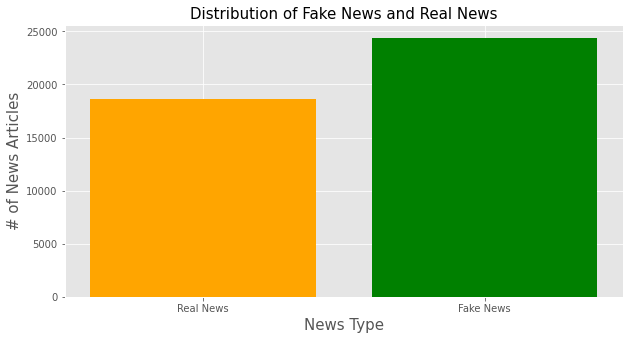

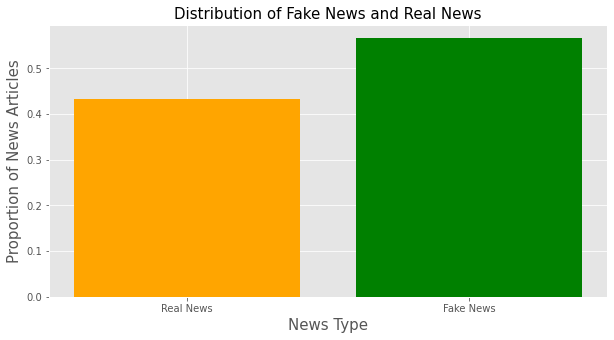

In [ ]:
# Plot Fake News / Real News
display_distribution(df)

In [ ]:
pp_diff = (len(df[df['real']==0]) - len(df[df['real']==1])) * 100 / len(df)
print(f"Percent point different: {pp_diff}")

Percent point different: 13.367591322342875


As the world is filled with fake news (now thanks to A.I. those can be automatically generated) we can accept that distribution

In [ ]:
# Save the second checkpoint of the data (not releated to project checkpoints!)
df.to_csv("data/train-checkpoint2.csv", index=None)

## Simple global text analysis 

### Text length

<Axes: >

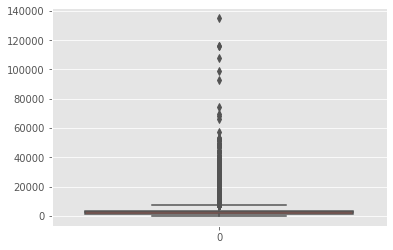

In [ ]:
sns.boxplot(df["text"].apply(len))

<Axes: xlabel='text', ylabel='Count'>

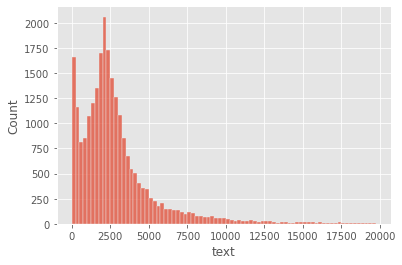

In [ ]:
sns.histplot(df[df["real"] == 0]["text"].apply(len), bins = range(0, 20000, 250)) # Distribution for fake news

<Axes: xlabel='text', ylabel='Count'>

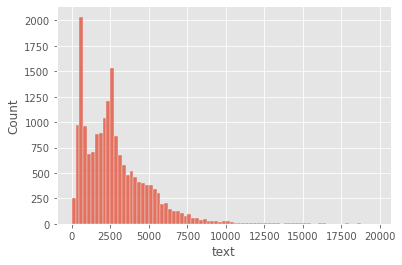

In [ ]:
sns.histplot(df[df["real"] == 1]["text"].apply(len), bins = range(0, 20000, 250)) # Distribution for real news

### Number of words

In [ ]:
def text_splitter(text: str) -> Iterable[str]:
  text = text.lower()
  # Replace non words with space
  text = re.sub(r"\W", " ", text)
  # Replace additional spaces with single space
  text = re.sub(r"[\s\n]+", " ", text)
  return np.array(text.strip().split(" "))

In [ ]:
text_sample = df["text"][0]
print(text_splitter(text_sample))

['isis' 'leader' 'hiding' ... 'author' 'or' 'representative']


In [ ]:
df2 = df.copy()
df2["text"] = df2["text"].apply(text_splitter)

<Axes: >

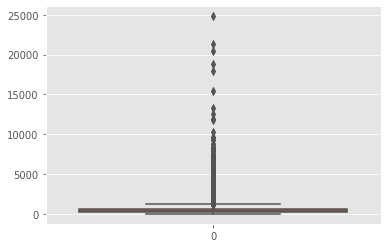

In [ ]:
sns.boxplot(df2["text"].apply(len))

<Axes: xlabel='text', ylabel='Count'>

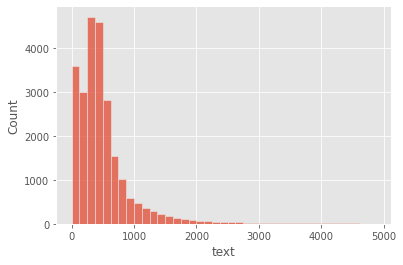

In [ ]:
sns.histplot(df2[df2["real"] == 0]["text"].apply(len), bins = range(0, 5000, 125)) # Distribution for fake news

<Axes: xlabel='text', ylabel='Count'>

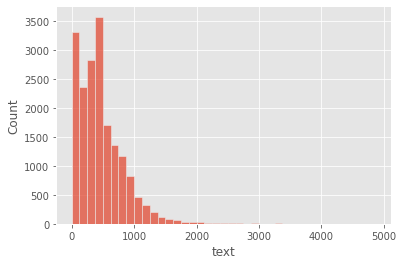

In [ ]:
sns.histplot(df2[df2["real"] == 1]["text"].apply(len), bins = range(0, 5000, 125)) # Distribution for news

In [ ]:
df2["word_len_mean"] = df2["text"].apply(lambda x: np.vectorize(len)(x).mean())

<Axes: >

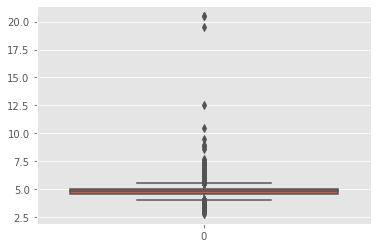

In [ ]:
sns.boxplot(df2["word_len_mean"])

<Axes: xlabel='word_len_mean', ylabel='Count'>

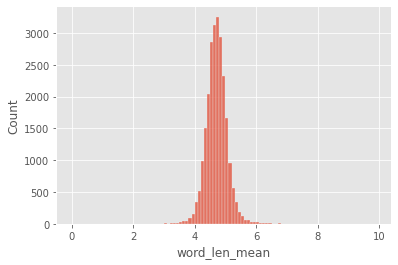

In [ ]:
sns.histplot(df2[df2["real"] == 0]["word_len_mean"], bins = np.arange(0, 10, 0.1)) # Distribution for fake news

<Axes: xlabel='word_len_mean', ylabel='Count'>

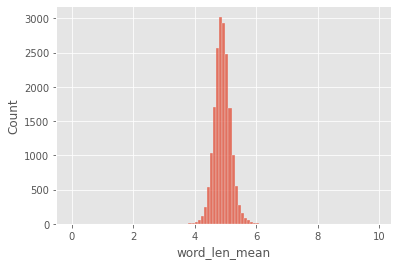

In [ ]:
sns.histplot(df2[df2["real"] == 1]["word_len_mean"], bins = np.arange(0, 10, 0.1)) # Distribution for real news

## Model train/test split

### (Optional) Load from 2. checkpoint

In [2]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint2.zip && unzip -d data train-checkpoint2.zip

--2023-03-22 23:07:42--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint2.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint2.zip [following]
--2023-03-22 23:07:42--  https://raw.githubusercontent.com/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50750922 (48M) [application/zip]
Saving to: ‘train-checkpoint2.zip.1’

train-checkpoint2.z 100%[===================>]  48.40M   288MB/s    in 0.2s    

2023-03-22 23:07:42 (288 MB/s) - ‘tra

In [3]:
df = pd.read_csv("data/train-checkpoint2.csv", index_col=False)

In [4]:
df.head()

,text,real
0,Isis Leader ‘hiding in Mosul’ as Troops Storm ...,0
1,FORMER SPEAKER JOHN BOEHNER Goes Low…Calls Two...,0
2,MH370 search: Debris found in Reunion may give...,1
3,A leading US senator: US Supporting War in Sy...,0
4,Energy Update – Collective Gridwork Fluctuatio...,0


### Train/test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["real"], random_state=42, shuffle=True, test_size=0.2)

In [6]:
type(X_train)

pandas.core.series.Series

## Text processing - place for improvement

Normalization of data:

In [7]:
def normalize_text(text: str) -> str:
    text = text.lower()
    # Get rid of urls
    text = re.sub("https?://\S+|www\.\S+", "", text)
    # Get rid of non words and extra spaces
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"[\s\n]+", " ", text)
    return text.strip()

X_train = X_train.apply(normalize_text)

## Model building

Converting text to vectors:

In [8]:
MAX_VOCAB = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)

Application of padding (so we have the same length for each article):

In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_VOCAB, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

## Model fitting

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1033/1033 [==============================] - 105s 93ms/step - loss: 0.3584 - accuracy: 0.8259 - val_loss: 0.1843 - val_accuracy: 0.9279
Epoch 2/10
1033/1033 [==============================] - 43s 41ms/step - loss: 0.1426 - accuracy: 0.9539 - val_loss: 0.1554 - val_accuracy: 0.9439
Epoch 3/10
1033/1033 [==============================] - 37s 36ms/step - loss: 0.0832 - accuracy: 0.9738 - val_loss: 0.1587 - val_accuracy: 0.9404
Epoch 4/10
1033/1033 [==============================] - 37s 36ms/step - loss: 0.0506 - accuracy: 0.9856 - val_loss: 0.1885 - val_accuracy: 0.9436


Visualize our training over time:

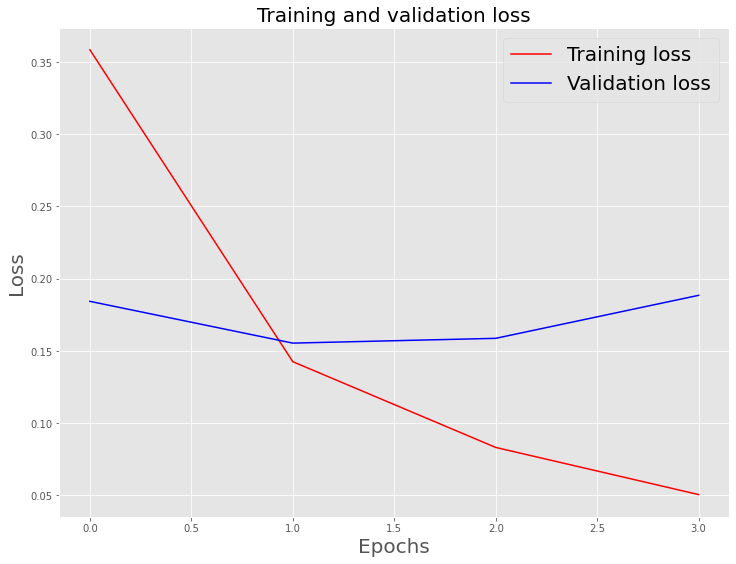

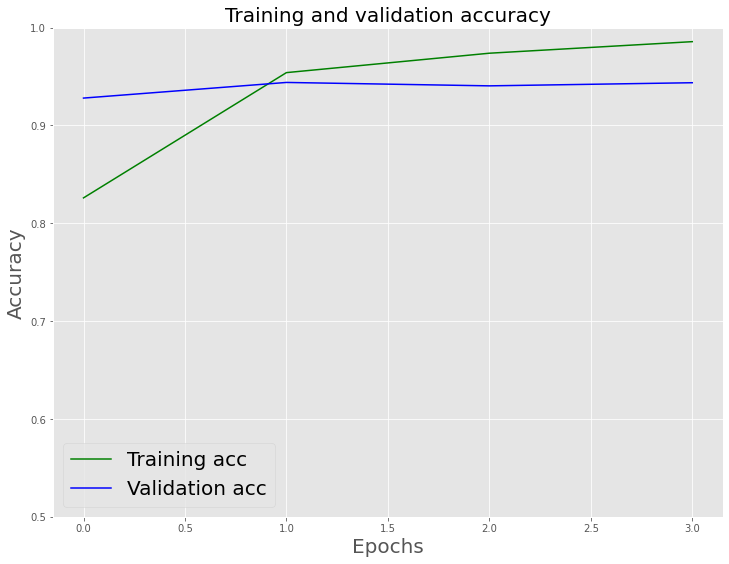

In [12]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Testing

In [13]:
X_test = X_test.apply(normalize_text)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Evaluation of the testing set:

In [14]:
model.evaluate(X_test, y_test)

269/269 [==============================] - 4s 14ms/step - loss: 0.1503 - accuracy: 0.9440


[0.15033264458179474, 0.9439665079116821]

In [22]:
y_pred = model.predict(X_test)
roc05 = (y_pred > 0.5) * 1

269/269 [==============================] - 4s 14ms/step


### Confusion Matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

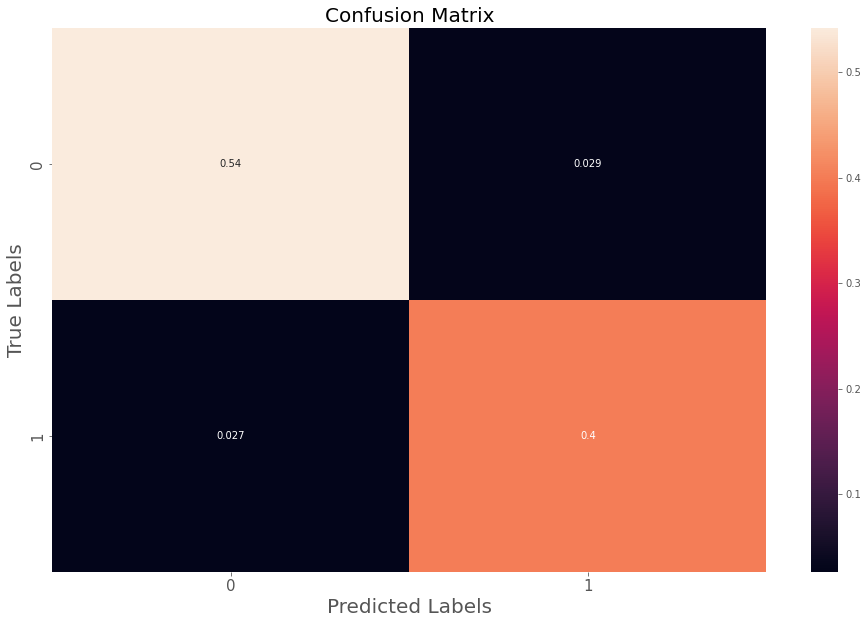

In [32]:
matrix = confusion_matrix(roc05, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel("Predicted Labels", size=20)
ax.set_ylabel("True Labels", size=20)
ax.set_title("Confusion Matrix", size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

### ROC Curve

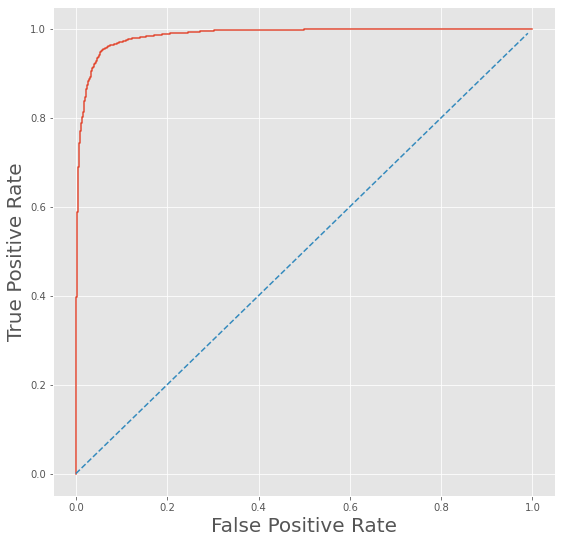

In [34]:
fpr, tpr, _ = roc_curve(y_test,  y_pred)

#create ROC curve
plt.figure(figsize=(9,9))
plt.plot(fpr,tpr)
xs = np.arange(0, 1, 0.01)
plt.plot(xs, xs, "--")
plt.ylabel("True Positive Rate", size=20)
plt.xlabel("False Positive Rate", size=20)
plt.show()